**Regularization**

Welcome to the second assignment of this week. Deep Learning models have so much flexibility and capacity that overfitting can be a serious problem, if the training dataset is not big enough. Sure it does well on the training set, but the learned network doesn't generalize to new examples that it has never seen!

You will learn to: Use regularization in your deep learning models.

Let's first import the packages you are going to use.

In [16]:
import numpy as np 
t = np.linspace(0, 1, 5)
t

array([2.5])

In [23]:
predictions = (t>0.5)
print(predictions)

[False False False  True  True]


In [44]:
p = np.array([[1,2,3]])
y = np.array([[1,2,1]])
# np.sum(y, keepdims = True)
np.dot(y, p.T)

array([[8]])

In [25]:
(p[0,:] == y[0,:])

array([ True,  True, False])

In [26]:
np.mean((p[0,:] == y[0,:]))

0.6666666666666666

In [27]:
np.random.randn(2, 3)

array([[ 0.90085595, -0.68372786, -0.12289023],
       [-0.93576943, -0.26788808,  0.53035547]])

Use %matplotlib notebook to get zoom-able & resize-able notebook. This is the best for quick tests where you need to work interactively.
Use %matplotlibe inline - this only draws the images, not interactive / zoom-able but it works well. I recommend to change figure size to be bigger than the default in most cases (see notes below on how).


In [28]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7., 4.) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

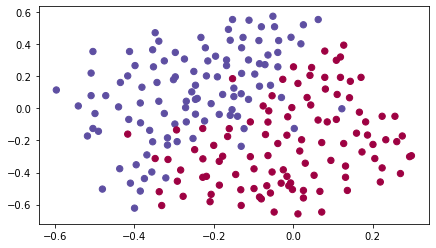

In [29]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.

* If the dot is blue, it means the French player managed to hit the ball with his/her head
* If the dot is red, it means the other team's player hit the ball with their head

Your goal: Use a deep learning model to find the positions on the field where the goalkeeper should kick the ball.

Analysis of the dataset: This dataset is a little noisy, but it looks like a diagonal line separating the upper left half (blue) from the lower right half (red) would work well.

You will first try a non-regularized model. Then you'll learn how to regularize it and decide which model you will choose to solve the French Football Corporation's problem.


**1 - Non-regularized model**
You will use the following neural network (already implemented for you below). This model can be used:

in regularization mode -- by setting the lambd input to a non-zero value. We use "lambd" instead of "lambda" because "lambda" is a reserved keyword in Python.
in dropout mode -- by setting the keep_prob to a value less than one
You will first try the model without any regularization. Then, you will implement:

L2 regularization -- functions: "compute_cost_with_regularization()" and "backward_propagation_with_regularization()"
Dropout -- functions: "forward_propagation_with_dropout()" and "backward_propagation_with_dropout()"
In each part, you will run this model with the correct inputs so that it calls the functions you've implemented. Take a look at the code below to familiarize yourself with the model.

In [30]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):

    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.1632998752572422
Cost after iteration 20000: 0.1385164242325374


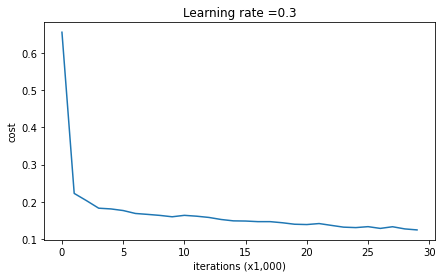

On the training set: 
Accuracy: 0.9478672985781991
On the test set: 
Accuracy: 0.915


In [31]:
parameters = model(train_X, train_Y)
print("On the training set: ")
predictions_train = predict(train_X, train_Y, parameters)
print("On the test set: ")
predictions_test = predict(test_X, test_Y, parameters)

The train accuracy is 94.8% while the test accuracy is 91.5%. This is the baseline model (you will observe the impact of regularization on this model). Run the following code to plot the decision boundary of your model.

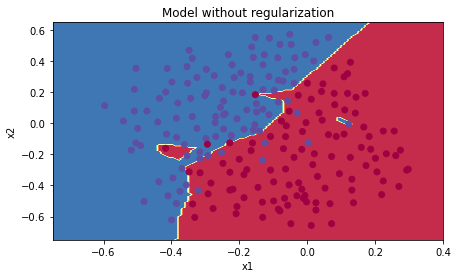

In [32]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

The non-regularized model is obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting.

**2 - L2 Regularization**

The standard way to avoid overfitting is called L2 regularization. It consists of appropriately modifying your cost function, from:
                
                        J=−1/m∑(y(i)log(a[L](i))+(1−y(i))log(1−a[L](i)))(1)
                        
Let's modify your cost and observe the consequences.

Exercise: Implement compute_cost_with_regularization() which computes the cost given by formula (2). To calculate ∑k∑jW[l]2k,j , use :

np.sum(np.square(Wl))
Note that you have to do this for W[1], W[2] and W[3], then sum the three terms and multiply by (1/m)*λ2.

In [33]:
# compute_cost_with_regularization
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    cross_entropy_cost = compute_cost(A3, Y)
    L2_regularization_cost = lambd/(2*m)*(np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    
    cost = cross_entropy_cost + L2_regularization_cost
    return cost


In [34]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.8120008094778446


Of course, because you changed the cost, you have to change backward propagation as well! All the gradients have to be computed with respect to this new cost.

Exercise: Implement the changes needed in backward propagation to take into account regularization. The changes only concern dW1, dW2 and dW3. For each, you have to add the regularization term's gradient (d/dW((1/2)(λ/m)W2)=λmW).

In [67]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1./m) * np.dot(dZ3, A2.T) + (lambd/m) * W3
    db3 = (1./m) * np.sum(dZ3, axis=1, keepdims=True) 
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = (1./m) * np.dot(dZ2, A1.T) + (lambd/m) * W2
    db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1>0))
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd/m) * W1
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {'dZ3': dZ3, 'dW3': dW3, 'db3':db3,
                'dA2': dA2, 'dZ2': dZ2, 'dW2': dW2, 'db2':db2,
                'dA1': dA1, 'dZ1': dZ1, 'dW1': dW1, 'db1':db1,}
    return gradients

In [72]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("dW2 = \n"+ str(grads["dW2"]))
print ("dW3 = \n"+ str(grads["dW3"]))
(grads["dW3"]<0.8).astype(int)

dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]


array([[1, 1, 1]])

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282238
Cost after iteration 20000: 0.26809163371273015


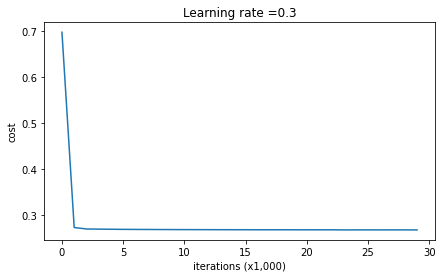

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [73]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

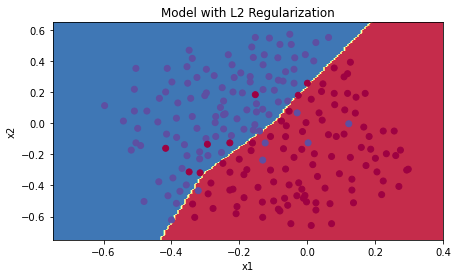

In [74]:
plt.title("Model with L2 Regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Observations:**

* The value of λ is a hyperparameter that you can tune using a dev set.
* L2 regularization makes your decision boundary smoother. If λ is too large, it is also possible to "oversmooth", resulting in a model with high bias.


What you should remember -- the implications of L2-regularization on:

# The cost computation:
    A regularization term is added to the cost
# The backpropagation function:
    There are extra terms in the gradients with respect to weight matrices
# Weights end up smaller ("weight decay"):
    Weights are pushed to smaller values.


# 3 - Dropout

Finally, dropout is a widely used regularization technique that is specific to deep learning. It randomly shuts down some neurons in each iteration. Watch these two videos to see what this means!

When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time.


In [101]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    
    np.random.seed(1)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    D1 = (D1 < keep_prob).astype(int)
    A1 = A1 * D1
    # Step 4: scale the value of neurons that haven't been shut down
    A1 = A1/keep_prob
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = (D2 < keep_prob).astype(int)
    A2 = A2 * D2
    A2 = A2/keep_prob
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache
    


In [102]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


# 3.2 - Backward propagation with dropout
Exercise: Implement the backward propagation with dropout. As before, you are training a 3 layer network. Add dropout to the first and second hidden layers, using the masks D[1] and D[2] stored in the cache.

Instruction: Backpropagation with dropout is actually quite easy. You will have to carry out 2 Steps:

You had previously shut down some neurons during forward propagation, by applying a mask D[1] to A1. In backpropagation, you will have to shut down the same neurons, by reapplying the same mask D[1] to dA1.
During forward propagation, you had divided A1 by keep_prob. In backpropagation, you'll therefore have to divide dA1 by keep_prob again (the calculus interpretation is that if A[1] is scaled by keep_prob, then its derivative dA[1] is also scaled by the same keep_prob).


In [125]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1./m) * np.dot(dZ3, A2.T)
    db3 = (1./m) * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = dA2 * D2
    dA2 = dA2 / keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2>0))
    dW2 = (1./m) * np.dot(dZ2, A1.T)
    db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1 * D1
    dA1 = dA1/keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1>0))
    dW1 = (1./m) * np.dot(dZ1, X.T)
    db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    return gradients

In [126]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = \n" + str(gradients["dA1"]))
print ("dA2 = \n" + str(gradients["dA2"]))

dA1 = 
[[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = 
[[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


Cost after iteration 0: 0.6543912405149825
Cost after iteration 10000: 0.0610169865749056
Cost after iteration 20000: 0.060582435798513114


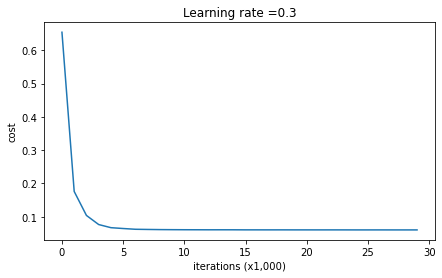

On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


In [127]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

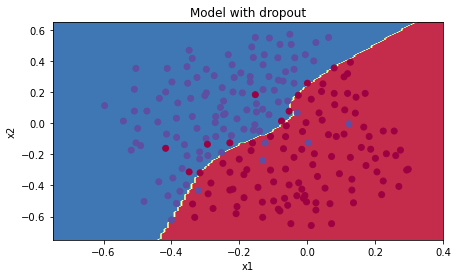

In [128]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

# Note:

* A common mistake when using dropout is to use it both in training and testing. You should use dropout (randomly eliminate nodes) only in training.
* Deep learning frameworks like tensorflow, PaddlePaddle, keras or caffe come with a dropout layer implementation. Don't stress - you will soon learn some of these frameworks.

What you should remember about dropout:

Dropout is a regularization technique.
You only use dropout during training. Don't use dropout (randomly eliminate nodes) during test time.
Apply dropout both during forward and backward propagation.
During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. You can check that this works even when keep_prob is other values than 0.5.

**What we want you to remember from this notebook:**

Regularization will help you reduce overfitting.
Regularization will drive your weights to lower values.
L2 regularization and Dropout are two very effective regularization techniques.